In [2]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# **Initializing objects:**

In [16]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')

Sat created


In [4]:
np.random.seed(seed=42)

my_scanner = Scanner(double_telescope=True) 
print('Scanner created')

vega =    (279.2333, 38.78,  128.91,  201.03,   286.23, -13.9)
proxima = (217.42,  -62,     768.7,  3775.40,   769.33,  21.7)
sirio =   (101.28,  -16.716, 379.21, -546.05, -1223.14,  -7.6)


# sources
num_sources = 2
alphas     = np.random.rand(num_sources)*(279 - 101 )+101
deltas     = np.random.rand(num_sources)*(38  + 62  )-62
parallaxes = np.random.rand(num_sources)*(768 - 128 )+128
mu_alphas  = np.random.rand(num_sources)*(3775+ 546 )-546
mu_deltas  = np.random.rand(num_sources)*(769 + 1223)-1223
mu_radials = np.random.rand(num_sources)*(21  + 7   )-7

sources = []
for n in range(num_sources):
    sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Scanner created
Sources created


In [5]:
# generate_observation_wrt_attitude(attitude)

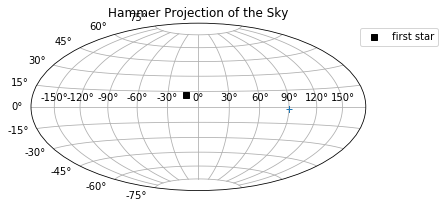

In [6]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate(sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [7]:
1/24*3

0.125

In [48]:
obs_times = []
calc_sources = []
for s in [sources[0]]:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    obs_times.append(my_scanner.obs_times)
    print('Error: ', my_scanner.scanner_error())
    calc_sources.append(Calc_source(obs_times=my_scanner.obs_times, source=s))
    print('------------------------------------------------------')


Starting scan with time from 0 to 365 days
Total measured time: 0.15002775192260742
How many observation time?  5
Error:  9.594547378810603e-14
------------------------------------------------------


In [37]:
source = sources[0]
sat=gaia
t=12
t0 = time.time()
for i in range(10000):
    #attitude = sat.func_attitude(t)
    Cu = source.unit_topocentric_function(sat, t)  # u in CoMRS frame
    #Su = ft.lmn_to_xyz(attitude, Cu)
print(time.time()-t0)

0.5473582744598389


In [26]:
print('att:',(1.5-0.9)/1.5*100 ,'%')

att: 40.0 %


In [27]:
my_scanner.obs_times

[97.39903812498333,
 122.36807300774394,
 122.515994931544,
 214.77272882280897,
 278.63292450240766]

# **2- Combine with solver:**

In [63]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [64]:
for s in calc_sources:
    noise_calc_sources(s)
    print(len(s.obs_times))

15


In [65]:
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=True)

In [77]:
# Solver.reset_iterations()
Solver.iterate(10)

***** Iteration: 31 *****
Error after iteration: 9.211923732407408e-23
***** Iteration: 32 *****
Error after iteration: 3.048104280119694e-23
***** Iteration: 33 *****
Error after iteration: 9.600552457117505e-24
***** Iteration: 34 *****
Error after iteration: 2.8915033872717322e-24
***** Iteration: 35 *****
Error after iteration: 8.36970139484836e-25
***** Iteration: 36 *****
Error after iteration: 2.332597475865386e-25
***** Iteration: 37 *****
Error after iteration: 6.264762222795116e-26
***** Iteration: 38 *****
Error after iteration: 1.627176386882995e-26
***** Iteration: 39 *****
Error after iteration: 4.06009168262621e-27
***** Iteration: 40 *****
Error after iteration: 9.592507856391581e-28


In [78]:
gaia.wz

25.132741228718345

# *Update Attitude*

In [55]:
np.array([1,3,2])-1

array([0, 2, 1])

In [46]:
np.radians(0.6)

0.010471975511965976

In [53]:
t_list = get_interesting_days(t_init, t_end, sat=gaia, source=sources[0])
t_list

0 : -0.3351702213060469
1 : -0.3121215845394691
2 : -0.2910083871943377
3 : -0.2721768437721091
4 : -0.2559737390427569
5 : -0.24274198276634049
6 : -0.23281467438625333
7 : -0.22650778742277702
8 : -0.22411175511816842
9 : -0.22588242223584734
10 : -0.23203199370196903
11 : -0.24272072384364637
12 : -0.25805011749259543
13 : -0.2780583359576131
14 : -0.3027183176879539
15 : -0.33193886009514667
16 : -0.3655686091515282
17 : -0.40340261827162366
18 : -0.4451909128155314
19 : -0.49064835983146954
20 : -0.5394651017686304
21 : -0.5913168563268365
22 : -0.6458744884389752
23 : -0.7028123957124702
24 : -0.7618153872319664
25 : -0.8225838519749014
26 : -0.884837082237126
27 : -0.9483146061934314
28 : -1.0127752285043181
29 : -1.0779930267722346
30 : -1.143748393477202
31 : -1.209809109997563
32 : -1.2758871575921733
33 : -1.34152441119696
34 : -1.4057184172844461
35 : -1.4652734970982617
36 : -1.505300280201431
37 : -1.4885913782351303
38 : -1.434556730780634
39 : -1.3715266207032843
40 : -

[59,
 60,
 96,
 97,
 98,
 121,
 122,
 123,
 124,
 213,
 214,
 215,
 216,
 242,
 243,
 278,
 279]

In [29]:
spline_degree = 3
Solver = Agis(gaia, calc_sources, real_sources=sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

In [30]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-8
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs[:] = Solver.att_coeffs[:] + c_noise[:]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  49.658372048309296
c_noise shape:  (4, 1461)
Error after Noise:  49.65837213789027


**Plot matrices:**

In [35]:
print(Solver.att_knots.shape)
print(Solver.att_coeffs.shape[1])

(1464,)
1461


In [31]:
N_aa = Solver.compute_attitude_LHS()

1461


IndexError: index 1464 is out of bounds for axis 0 with size 1464

In [ ]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=1)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')

# **See iterations**

In [17]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.grid(), plt.legend(), plt.show()
multi_compare_attitudes(gaia, Solver, my_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)

***** Iteration: 1 *****
1461


IndexError: index 1464 is out of bounds for axis 0 with size 1464